In [440]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


print("TensorFlow version:", tf.__version__)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

TensorFlow version: 2.13.0
PyTorch version: 2.9.1
CUDA available: False
Using device: cpu


In [441]:
data_dir = "data/"
files = sorted(glob.glob(os.path.join(data_dir, "*.csv")))

dfs = []
for f in files:
    df = pd.read_csv(f)
    df.sort_values("start_time", inplace=True)
    dfs.append(df)

print("Number of clusters loaded:", len(dfs))
print("Files:", files)
dfs[0].head()



Number of clusters loaded: 8
Files: ['data/preprocessed_data_cluster_1.csv', 'data/preprocessed_data_cluster_2.csv', 'data/preprocessed_data_cluster_3.csv', 'data/preprocessed_data_cluster_4.csv', 'data/preprocessed_data_cluster_5.csv', 'data/preprocessed_data_cluster_6.csv', 'data/preprocessed_data_cluster_7.csv', 'data/preprocessed_data_cluster_8.csv']


,cluster,start_time,cpu,memory
0,1.0,265,0.504545,0.605505
1,1.0,415,0.293182,0.661315
2,1.0,620,0.321818,0.482416
3,1.0,1035,0.423636,0.281346
4,1.0,1180,0.038466,0.357416


In [442]:
def create_windows(df, window_size=40):
    """
    df: preprocessed DataFrame with columns ['cpu', 'memory']
    window_size: number of past timesteps used for prediction
    """
    data = df[['cpu', 'memory']].values  # already normalized
    X, y = [], []
    
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])    # sequence of shape (window_size, 2)
        y.append(data[i+window_size])      # next timestep (cpu, memory)
    
    return np.array(X), np.array(y)


In [443]:
window_size = 40

X_all = []
y_all = []

for df in dfs:
    X, y = create_windows(df, window_size)
    X_all.append(X)
    y_all.append(y)

# Combine all clusters
X = np.concatenate(X_all)
y = np.concatenate(y_all)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)



Shape of X: (1715, 40, 2)
Shape of y: (1715, 2)
Train: (1200, 40, 2) (1200, 2)
Validation: (257, 40, 2) (257, 2)
Test: (258, 40, 2) (258, 2)


In [444]:
batch_size = 64

# Convert to torch tensors
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [445]:
class SimpleLSTMForecaster(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=2, num_layers=1, dropout=0.1):
        super(SimpleLSTMForecaster, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)         # output shape: (batch, seq_len, hidden_size)
        lstm_out = self.dropout(lstm_out)
        
        last_output = lstm_out[:, -1, :]   # take last timestep
        out = self.fc(last_output)
        
        return out



In [446]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleLSTMForecaster().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

epochs = 100
train_losses = []
val_losses = []

best_val_loss = float('inf')  # Initialize best validation loss
best_model_path = "best_lstm_forecaster.pth"

for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            loss = criterion(output, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch}/{epochs} — Train Loss: {epoch_loss:.6f} — Val Loss: {val_loss:.6f}")

# --- Save the best model ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"--> New best model saved at epoch {epoch} with val_loss={val_loss:.6f}")

print(f"Training complete. Best model saved as {best_model_path}")

Using device: cpu
Epoch 1/100 — Train Loss: 0.034306 — Val Loss: 0.024312
--> New best model saved at epoch 1 with val_loss=0.024312
Epoch 2/100 — Train Loss: 0.028348 — Val Loss: 0.024034
--> New best model saved at epoch 2 with val_loss=0.024034
Epoch 3/100 — Train Loss: 0.028072 — Val Loss: 0.023699
--> New best model saved at epoch 3 with val_loss=0.023699
Epoch 4/100 — Train Loss: 0.028199 — Val Loss: 0.023878
Epoch 5/100 — Train Loss: 0.027977 — Val Loss: 0.023785
Epoch 6/100 — Train Loss: 0.027981 — Val Loss: 0.023785
Epoch 7/100 — Train Loss: 0.028055 — Val Loss: 0.024049
Epoch 8/100 — Train Loss: 0.027973 — Val Loss: 0.023924
Epoch 9/100 — Train Loss: 0.027995 — Val Loss: 0.023738
Epoch 10/100 — Train Loss: 0.027892 — Val Loss: 0.023678
--> New best model saved at epoch 10 with val_loss=0.023678
Epoch 11/100 — Train Loss: 0.028003 — Val Loss: 0.023870
Epoch 12/100 — Train Loss: 0.028018 — Val Loss: 0.024127
Epoch 13/100 — Train Loss: 0.027951 — Val Loss: 0.023998
Epoch 14/100 

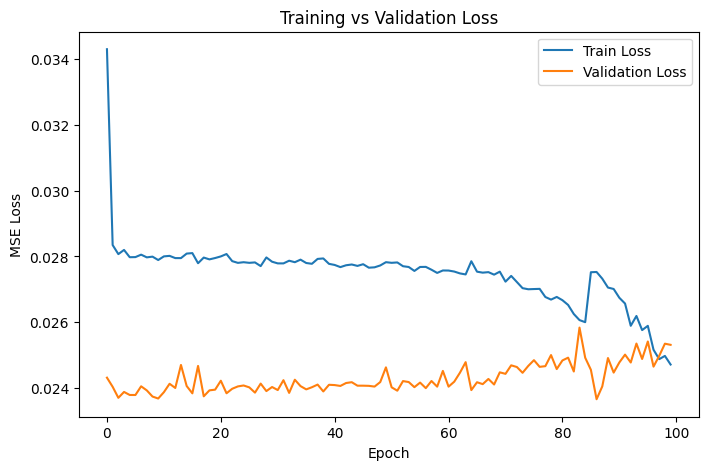

In [447]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [448]:
# Full Test Set Predictions
model.eval()
y_preds = []
y_trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        output = model(xb)
        y_preds.append(output.cpu().numpy())
        y_trues.append(yb.cpu().numpy())

y_preds = np.vstack(y_preds)   # shape (num_samples, 2)
y_trues = np.vstack(y_trues)   # shape (num_samples, 2)

# MSE
mse = mean_squared_error(y_trues, y_preds)
print("Test MSE:", mse)

# RMSE
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# MAE
mae = mean_absolute_error(y_trues, y_preds)
print("Test MAE:", mae)

# R^2 Score
r2 = r2_score(y_trues, y_preds)
print("Test R^2:", r2)


Test MSE: 0.05792434513568878
Test RMSE: 0.2406747704594081
Test MAE: 0.1858225166797638
Test R^2: -0.12349188327789307


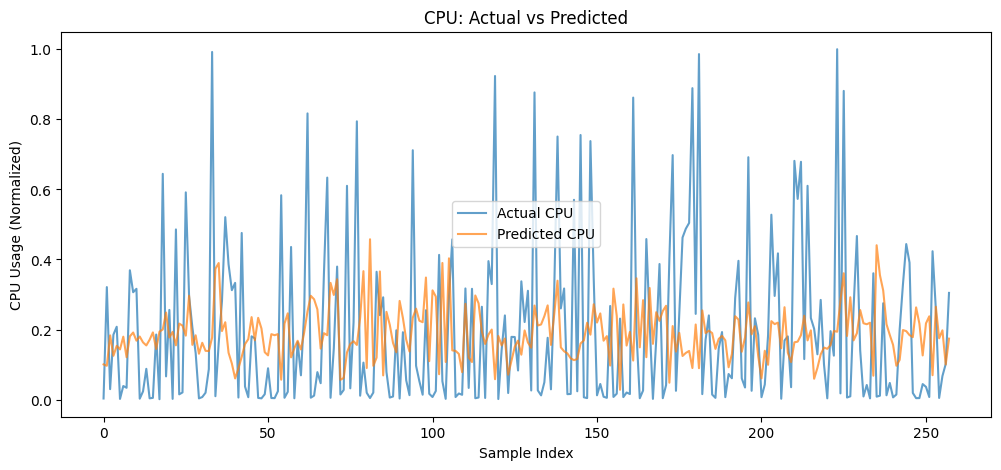

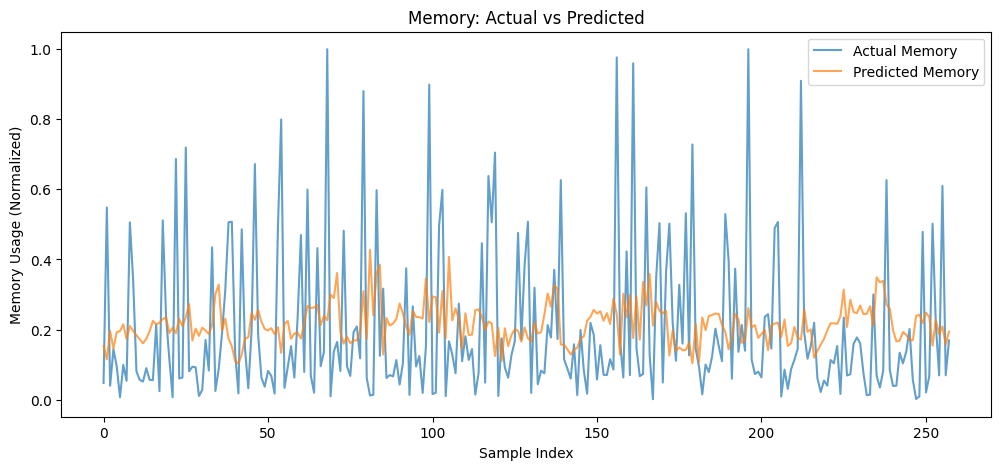

In [449]:
plt.figure(figsize=(12,5))
plt.plot(y_trues[:,0], label='Actual CPU', alpha=0.7)
plt.plot(y_preds[:,0], label='Predicted CPU', alpha=0.7)
plt.title("CPU: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("CPU Usage (Normalized)")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_trues[:,1], label='Actual Memory', alpha=0.7)
plt.plot(y_preds[:,1], label='Predicted Memory', alpha=0.7)
plt.title("Memory: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Memory Usage (Normalized)")
plt.legend()
plt.show()

In [450]:
sample_x = X_test[100:101]  # pick a test seq
sample_x_torch = torch.Tensor(sample_x).to(device)

model.eval()
pred = model(sample_x_torch).cpu().detach().numpy()

print("Last input timestep:", sample_x[0][-1])
print("Predicted next:", pred[0])
print("Actual next:", y_test[100])

Last input timestep: [0.01689996 0.89905853]
Predicted next: [0.31196874 0.29419976]
Actual next: [0.00756836 0.01601475]


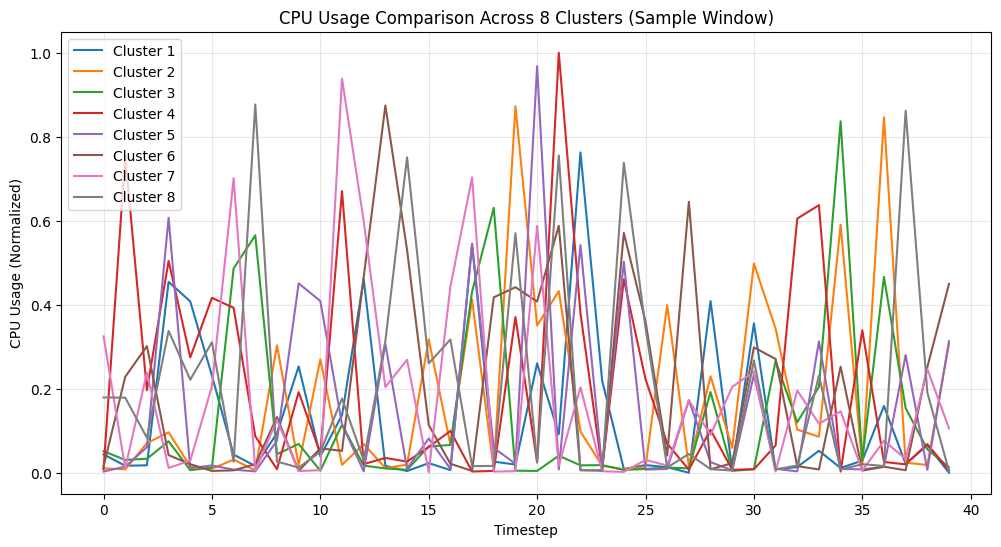

In [451]:
# Number of clusters
num_clusters = len(dfs)

# Randomly pick one sequence from each cluster for comparison
window_size = 40  # same as used in your sliding window
plt.figure(figsize=(12,6))

for i, df in enumerate(dfs):
    # Ensure cluster has enough timesteps
    if len(df) <= window_size:
        continue
    
    # Pick a random start index
    start_idx = np.random.randint(0, len(df) - window_size)
    window = df['cpu'].values[start_idx:start_idx+window_size]
    
    plt.plot(range(window_size), window, label=f'Cluster {i+1}')

plt.title("CPU Usage Comparison Across 8 Clusters (Sample Window)")
plt.xlabel("Timestep")
plt.ylabel("CPU Usage (Normalized)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()